In [18]:
import pandas as pd
from textblob import TextBlob
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import json
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datasketch import MinHash, MinHashLSH
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import contractions
import pandas as pd
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.quality import modularity


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
file_path = "../data/fake reviews dataset.csv"
df = pd.read_csv(file_path)

In [20]:
df = df.rename(columns={'text_':'text'})
df['category']=df['category'].str.replace('_5','',regex=False)

In [21]:
df.drop_duplicates()

,category,rating,label,text
0,Home_and_Kitchen,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen,5,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry,4,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry,5,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry,2,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry,1,CG,I liked nothing about this dress. The only rea...


https://datastud.dev/posts/nlp-preprocess

In [22]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Download necessary NLTK data (only needed the first time)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_column(df, column_name):
    """
    Preprocesses a specified column in a DataFrame by applying:
    - Punctuation removal
    - Stopword removal
    - Lemmatization

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to preprocess.

    Returns:
        pd.DataFrame: The DataFrame with a new 'processed_text' column.
    """
    def preprocess_text(text):
        # Tokenize the text
        tokens = word_tokenize(text)
        
        # Remove punctuation
        tokens = [token for token in tokens if token not in set(string.punctuation)]
        
        # Remove stopwords
        tokens = [token for token in tokens if token.lower() not in stopwords.words('english')]
        
        # Lemmatize tokens
        lem = WordNetLemmatizer()
        for part_of_speech in ['n', 'v', 'a', 'r', 's']:
            tokens = [lem.lemmatize(token, part_of_speech).lower() for token in tokens]

        tokens = [token for token in tokens if token.isalnum() and not token.isdigit() and len(token) >= 2]
        tokens = [token for token in tokens if not any(char.isdigit() for char in token)]

        return tokens

    # Apply preprocessing to the specified column
    df['processed_text'] = df[column_name].apply(preprocess_text)
    
    return df


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
df = preprocess_column(df, column_name='text' )

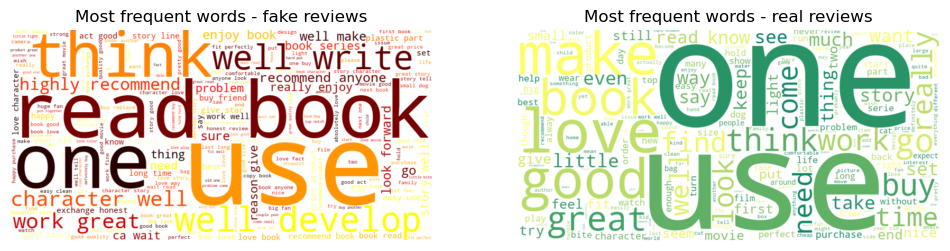

In [142]:
# Separate CG and OR reviews
cg_text = ' '.join([' '.join(words) for words in df[df['label'] == 'CG']['processed_text']])
or_text = ' '.join([' '.join(words) for words in df[df['label'] == 'OR']['processed_text']])

# Generate word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cg_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='hot').generate(cg_text)
plt.imshow(cg_wordcloud, interpolation='bilinear')
plt.title('Most frequent words - fake reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
or_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='summer').generate(or_text)
plt.imshow(or_wordcloud, interpolation='bilinear')
plt.title('Most frequent words - real reviews')
plt.axis('off')

plt.show()

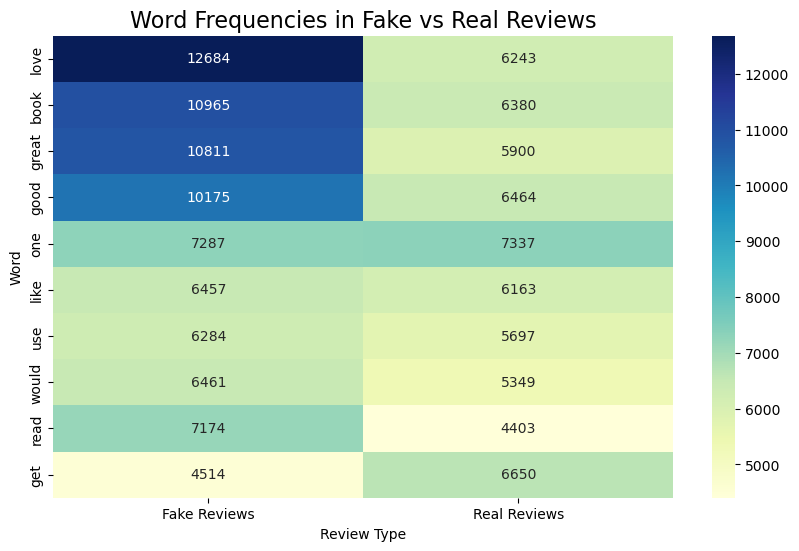

In [26]:
import seaborn as sns

# Count word frequencies for fake and real reviews
cg_word_counts = Counter(cg_text.split())
or_word_counts = Counter(or_text.split())

# Combine counts into a DataFrame
words = list(set(cg_word_counts.keys()).union(or_word_counts.keys()))
word_frequencies = pd.DataFrame({
    "Word": words,
    "Fake Reviews": [cg_word_counts.get(word, 0) for word in words],
    "Real Reviews": [or_word_counts.get(word, 0) for word in words]
}).set_index("Word")

# Select top words based on total frequency
top_words = word_frequencies.sum(axis=1).nlargest(10).index
heatmap_data = word_frequencies.loc[top_words]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Word Frequencies in Fake vs Real Reviews", fontsize=16)
plt.xlabel("Review Type")
plt.ylabel("Word")
plt.show()

In [28]:
# Count word frequencies for real reviews
or_word_counts = Counter(or_text.split())
top_words = list(set(cg_word_counts.keys()).union(or_word_counts.keys()))

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Word": top_words,
    "Fake Reviews": [cg_word_counts.get(word, 0) for word in top_words],
    "Real Reviews": [or_word_counts.get(word, 0) for word in top_words]
})

# Get the top 20 words by total frequency
comparison_df["Total"] = comparison_df["Fake Reviews"] + comparison_df["Real Reviews"]
top_comparison = comparison_df.nlargest(20, "Total")

# Melt DataFrame for Plotly Express
melted_df = top_comparison.melt(id_vars=["Word"], value_vars=["Fake Reviews", "Real Reviews"], var_name="Review Type", value_name="Frequency")

# Create side-by-side bar chart
fig = px.bar(
    melted_df,
    x="Word",
    y="Frequency",
    color="Review Type",
    barmode="group",
    title="Top Words: Fake vs Real Reviews",
    labels={"Word": "Word", "Frequency": "Frequency", "Review Type": "Type"}
)
fig.update_layout(title_font_size=18, xaxis_tickangle=45)
fig.show()

/Users/vedisingvars/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/vedisingvars/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [136]:
label_counts = df['label'].value_counts(normalize=True).reset_index()
label_counts.columns = ['label', 'proportion']

# Plot the proportions
fig = px.bar(label_counts, x='label', y='proportion', title='Count of OR and CG reviews',
             labels={'label': 'Label', 'proportion': 'Proportion'},
             color='label', color_discrete_sequence=['skyblue', 'salmon'])

fig.show()

/Users/vedisingvars/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/vedisingvars/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



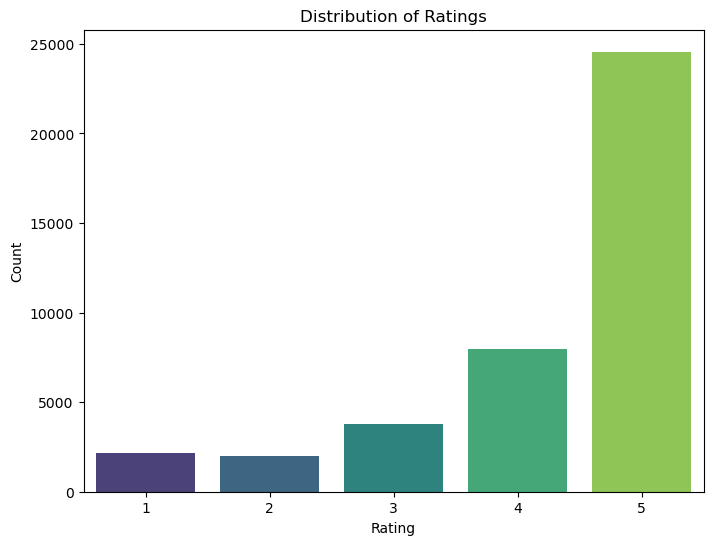

In [137]:

# Plot distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

/var/folders/9w/dgxmbyyn2hl1p64rjgpmgw880000gn/T/ipykernel_12895/1687703350.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




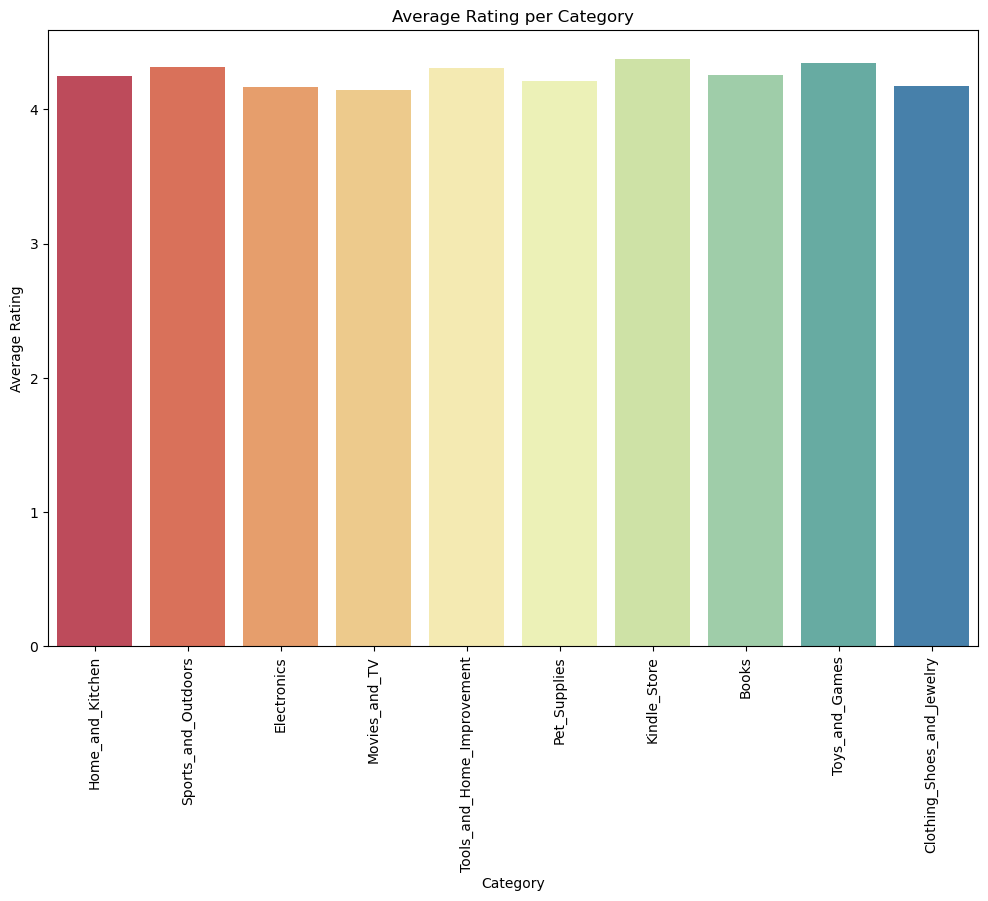

In [72]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='category', y='rating', estimator='mean', ci=None, palette='Spectral')
plt.xticks(rotation=90)
plt.title('Average Rating per Category')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.show()

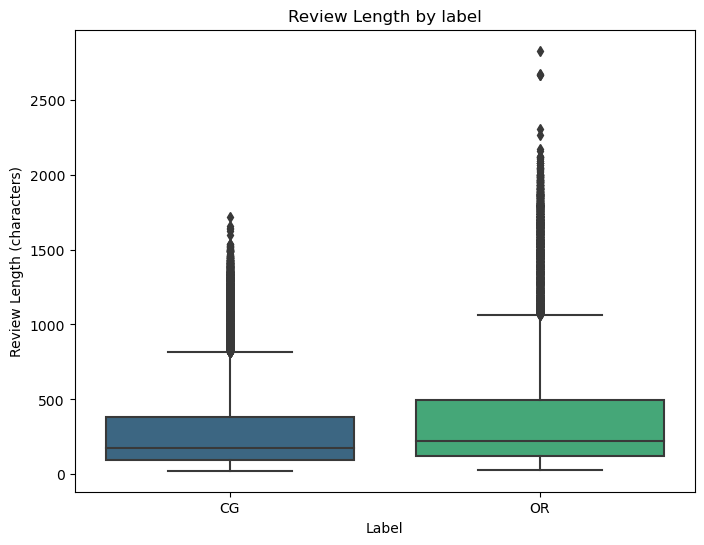

In [73]:
# Add a column for review length
df['review_length'] = df['text'].apply(len)

# Plot review length by rating
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='label', y='review_length', palette='viridis')
plt.title('Review Length by label')
plt.xlabel('Label')
plt.ylabel('Review Length (characters)')
plt.show()

In [138]:
# Count the occurrences of each category
category_counts = df['category'].value_counts()

# Display the category with the most reviews
most_reviews_category = category_counts.idxmax()
most_reviews_count = category_counts.max()

print(f"Category with the most reviews: {most_reviews_category} ({most_reviews_count} reviews)")

Category with the most reviews: Kindle_Store (4730 reviews)


In [6]:
# Text preprocessing and TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['processed_text'].apply(' '.join))

# Compute similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

In [7]:
# Threshold for similarity to create edges in the graph
threshold = 0.5

# Create a graph
G = nx.Graph()

# Add nodes (each review is a node)
for i, review in enumerate(df['processed_text']):
    G.add_node(i, category=df['category'][i], label=df['label'][i], rating=df['rating'][i])

# Add edges based on similarity
for i in range(similarity_matrix.shape[0]):
    for j in range(i + 1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

# Print graph summary
print(f"Graph Summary:\nNodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}\nIs Directed: {nx.is_directed(G)}")

Graph Summary:
Nodes: 40432
Edges: 335842
Is Directed: False


Nodes: 40,432
This is the total number of distinct entities in your graph. In your case, each review (or reviewer, depending on how you constructed the graph) is represented as a node.

Edges: 335,842
These are the connections or relationships between the nodes.
In your case, an edge is created based on similarity between reviews (e.g., text similarity or shared attributes like category or reviewer).

s Directed: False
This indicates your graph is undirected, meaning the edges between nodes have no direction.
Example: If a similarity exists between Review A and Review B, it is treated as a mutual relationship, i.e., A is connected to B, and B is connected to A.

## Frequent items: apriori

In [72]:
baskets = df['processed_text'].apply(lambda x: list(set(x)))

te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(df_te, min_support=0.05, use_colnames=True)


In [73]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.118520,(also),1
1,0.053423,(anyone),1
2,0.056243,(best),1
3,0.056886,(big),1
4,0.090003,(bite),1
...,...,...,...
158,0.056985,"(would, use)",2
159,0.050084,"(work, well)",2
160,0.057949,"(would, well)",2
161,0.050183,"(character, book, read)",3


In [74]:
df_te

,aa,aaa,aaas,aac,aack,aahhs,aaj,aaliyah,aames,aaron,...,zuke,zulus,zuma,zumba,zumiez,zune,zuppies,zurg,zyliss,zymox
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40427,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40428,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40429,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40430,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [76]:
num_itemsets = len(frequent_itemsets)
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=num_itemsets)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(character),(book),0.102048,0.161679,0.067249,0.658992,4.075930,1.0,0.050750,2.458360,0.840420,0.342271,0.593225,0.537466
1,(read),(book),0.145034,0.161679,0.104843,0.722885,4.471119,1.0,0.081394,3.025179,0.908038,0.519358,0.669441,0.685674
2,(book),(read),0.161679,0.145034,0.104843,0.648463,4.471119,1.0,0.081394,2.432078,0.926068,0.519358,0.588829,0.685674
3,(character),(story),0.102048,0.131233,0.068386,0.670141,5.106507,1.0,0.054994,2.633750,0.895562,0.414729,0.620313,0.595624
4,(recommend),(would),0.125618,0.187648,0.086145,0.685765,3.654520,1.0,0.062573,2.585172,0.830720,0.379288,0.613178,0.572420
5,"(character, book)",(read),0.067249,0.145034,0.050183,0.746230,5.145222,1.0,0.040430,3.369063,0.863730,0.309582,0.703182,0.546120
6,"(character, read)",(book),0.058271,0.161679,0.050183,0.861205,5.326642,1.0,0.040762,6.040014,0.862524,0.295600,0.834437,0.585796
7,"(read, story)",(book),0.066185,0.161679,0.053596,0.809791,5.008637,1.0,0.042895,4.407362,0.857070,0.307550,0.773107,0.570644
8,"(book, story)",(read),0.074916,0.145034,0.053596,0.715418,4.932770,1.0,0.042731,3.004284,0.861840,0.322183,0.667142,0.542480


## FAKE vs REAL

In [48]:
# Split into real and fake reviews
real_reviews = df[df['label'] == "OR"]  # Real reviews
fake_reviews = df[df['label'] == "CG"]  # Fake reviews


In [49]:
# Create baskets for real and fake reviews
real_baskets = real_reviews['processed_text'].tolist()
fake_baskets = fake_reviews['processed_text'].tolist()


In [50]:
# Encode real reviews
te = TransactionEncoder()
real_encoded = te.fit(real_baskets).transform(real_baskets)
real_df = pd.DataFrame(real_encoded, columns=te.columns_)

# Find frequent itemsets for real reviews
real_itemsets = apriori(real_df, min_support=0.05, use_colnames=True)
num_itemsets_real=len(real_itemsets)
# Generate association rules for real reviews
real_rules = association_rules(real_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=num_itemsets_real)

In [41]:
real_itemsets

,support,itemsets
0,0.098585,(also)
1,0.074001,(back)
2,0.153047,(book)
3,0.141522,(buy)
4,0.072368,(character)
...,...,...
62,0.088000,"(one, get)"
63,0.076128,"(good, like)"
64,0.079244,"(good, one)"
65,0.083350,"(one, like)"


In [27]:
real_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(read),(book),0.1435,0.153047,0.088643,0.617718,4.03613,1.0,0.06668,2.215519,0.87827,0.426362,0.548638,0.598452


In [51]:
# Encode real reviews
te = TransactionEncoder()
fake_encoded = te.fit(fake_baskets).transform(fake_baskets)
fake_df = pd.DataFrame(fake_encoded, columns=te.columns_)

# Find frequent itemsets for real reviews
fake_itemsets = apriori(fake_df, min_support=0.05, use_colnames=True)
num_itemsets_fake = len(fake_itemsets)
# Generate association rules for real reviews
fake_rules = association_rules(fake_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=num_itemsets_fake)

In [29]:
fake_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(anyone),(great),0.082212,0.331767,0.052879,0.643201,1.938713,1.0,0.025604,1.872856,0.527566,0.146438,0.466056,0.401293
1,(anyone),(recommend),0.082212,0.169519,0.077661,0.944645,5.572496,1.0,0.063725,15.002816,0.894049,0.446149,0.933346,0.701386
2,(anyone),(would),0.082212,0.199693,0.068510,0.833333,4.173066,1.0,0.052093,4.801840,0.828479,0.321048,0.791747,0.588205
3,(author),(book),0.061882,0.170311,0.054066,0.873701,5.130044,1.0,0.043527,6.569249,0.858175,0.303527,0.847776,0.595578
4,(character),(book),0.131727,0.170311,0.091858,0.697334,4.094482,1.0,0.069423,2.741269,0.870428,0.437044,0.635205,0.618345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,"(good, great, would)",(recommend),0.062673,0.169519,0.050999,0.813733,4.800242,1.0,0.040375,4.458556,0.844612,0.281463,0.775712,0.557290
104,"(love, recommend, great)",(would),0.067521,0.199693,0.055946,0.828571,4.149220,1.0,0.042462,4.668456,0.813949,0.264809,0.785796,0.554365
105,"(love, recommend, would)",(great),0.078205,0.331767,0.055946,0.715370,2.156243,1.0,0.030000,2.347726,0.581724,0.158027,0.574056,0.442000
106,"(love, great, would)",(recommend),0.069549,0.169519,0.055946,0.804410,4.745242,1.0,0.044156,4.246022,0.848258,0.305511,0.764485,0.567218


In [30]:
real_vocab = set([word for basket in real_baskets for word in basket])
fake_vocab = set([word for basket in fake_baskets for word in basket])

print("Number of unique tokens in real reviews:", len(real_vocab))
print("Number of unique tokens in fake reviews:", len(fake_vocab))


Number of unique tokens in real reviews: 27736
Number of unique tokens in fake reviews: 9004


In [31]:
print("Number of frequent itemsets for real reviews:", len(real_itemsets))
print("Number of frequent itemsets for fake reviews:", len(fake_itemsets))

Number of frequent itemsets for real reviews: 229
Number of frequent itemsets for fake reviews: 496


In [53]:
thresholds = [0.02, 0.03, 0.05, 0.07]
for threshold in thresholds:
    fake_itemsets = apriori(fake_df, min_support=threshold, use_colnames=True)
    real_itemsets = apriori(real_df, min_support=threshold, use_colnames=True)
    print(f"Threshold: {threshold}")
    print(f"Fake Itemsets: {len(fake_itemsets)}, Real Itemsets: {len(real_itemsets)}")


Threshold: 0.02
Fake Itemsets: 3922, Real Itemsets: 1195
Threshold: 0.03
Fake Itemsets: 1134, Real Itemsets: 442
Threshold: 0.05
Fake Itemsets: 272, Real Itemsets: 138
Threshold: 0.07
Fake Itemsets: 108, Real Itemsets: 67


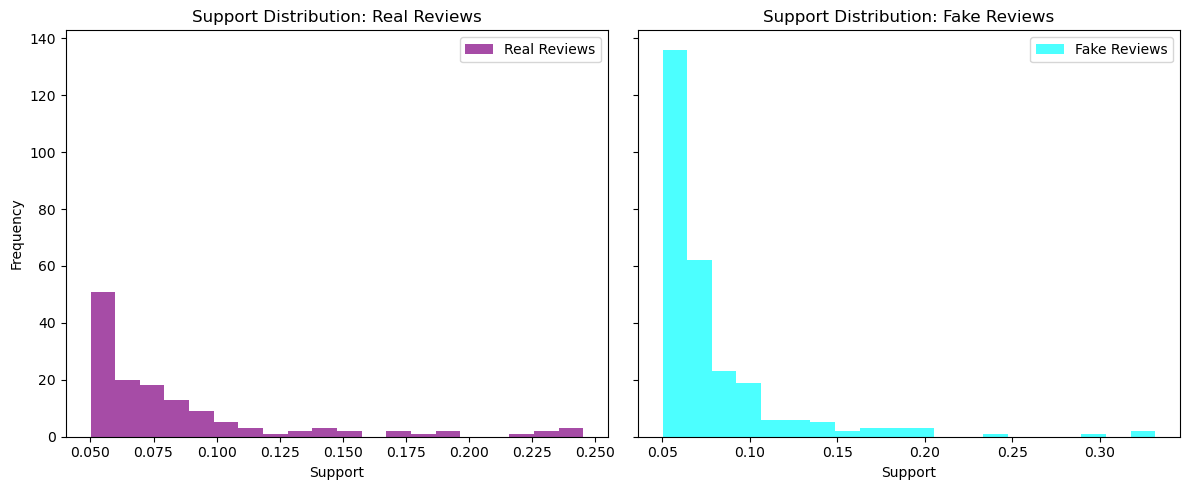

In [52]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Real Reviews Support Distribution
axes[0].hist(real_itemsets['support'], bins=20, color='purple', alpha=0.7, label='Real Reviews')
axes[0].set_title('Support Distribution: Real Reviews')
axes[0].set_xlabel('Support')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Fake Reviews Support Distribution
axes[1].hist(fake_itemsets['support'], bins=20, color='cyan', alpha=0.7, label='Fake Reviews')
axes[1].set_title('Support Distribution: Fake Reviews')
axes[1].set_xlabel('Support')
axes[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


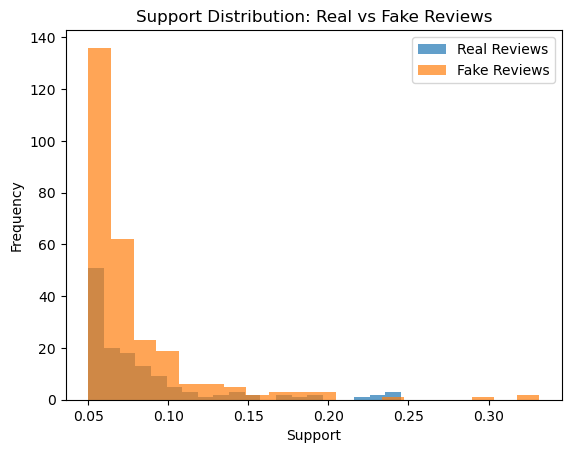

In [117]:
import matplotlib.pyplot as plt

# Support for real reviews
plt.hist(real_itemsets['support'], bins=20, alpha=0.7, label='Real Reviews')

# Support for fake reviews
plt.hist(fake_itemsets['support'], bins=20, alpha=0.7, label='Fake Reviews')

plt.xlabel('Support')
plt.ylabel('Frequency')
plt.legend()
plt.title('Support Distribution: Real vs Fake Reviews')
plt.show()


## SIMILAR ITEMS LSH


In [8]:
# Text preprocessing and TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['processed_text'].apply(' '.join))


In [10]:
from datasketch import MinHash

def compute_minhash(tokens, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for token in tokens:  # Iterate directly over the list of tokens
        m.update(token.encode('utf8'))
    return m

# Compute MinHash signatures for each review
df['minhash'] = df['processed_text'].apply(lambda tokens: compute_minhash(tokens))



In [14]:
from datasketch import MinHashLSH

# Initialize LSH with a similarity threshold
lsh = MinHashLSH(threshold=0.8, num_perm=128)

# Add MinHash objects to the LSH
for i, m in enumerate(df['minhash']):
    lsh.insert(f'review_{i}', m)

# Find similar reviews for each review
similar_reviews = {}
for i, m in enumerate(df['minhash']):
    result = lsh.query(m)
    # Filter out the review itself from the results
    result = [r for r in result if r != f'review_{i}']
    similar_reviews[f'review_{i}'] = result

# Display results
for key, value in similar_reviews.items():
    if value:  # Only print if there are similar reviews
        print(f"Review {key} is similar to: {value}")


Review review_143 is similar to: ['review_725']
Review review_403 is similar to: ['review_809']
Review review_424 is similar to: ['review_20491']
Review review_435 is similar to: ['review_4715']
Review review_511 is similar to: ['review_19981']
Review review_523 is similar to: ['review_15896', 'review_37230']
Review review_725 is similar to: ['review_143']
Review review_809 is similar to: ['review_403']
Review review_1204 is similar to: ['review_1503']
Review review_1363 is similar to: ['review_1768']
Review review_1379 is similar to: ['review_1428']
Review review_1428 is similar to: ['review_1379']
Review review_1503 is similar to: ['review_1204']
Review review_1555 is similar to: ['review_1911']
Review review_1674 is similar to: ['review_1681']
Review review_1681 is similar to: ['review_1674']
Review review_1768 is similar to: ['review_1363']
Review review_1911 is similar to: ['review_1555']
Review review_2042 is similar to: ['review_2048']
Review review_2048 is similar to: ['review_

In [15]:
# Separate fake and real reviews
fake_ids = set(df[df['label'] == 'CG'].index)
real_ids = set(df[df['label'] == 'OR'].index)

# Analyze similar reviews by label
fake_similarities = []
real_similarities = []
cross_similarities = []

for review_id, similar_ids in similar_reviews.items():
    review_id_num = int(review_id.split('_')[1])  # Extract numeric ID
    for similar_id in similar_ids:
        similar_id_num = int(similar_id.split('_')[1])
        if review_id_num in fake_ids and similar_id_num in fake_ids:
            fake_similarities.append((review_id_num, similar_id_num))
        elif review_id_num in real_ids and similar_id_num in real_ids:
            real_similarities.append((review_id_num, similar_id_num))
        elif (review_id_num in fake_ids and similar_id_num in real_ids) or (
            review_id_num in real_ids and similar_id_num in fake_ids
        ):
            cross_similarities.append((review_id_num, similar_id_num))


In [16]:
print(f"Number of fake-to-fake similarities: {len(fake_similarities)}")
print(f"Number of real-to-real similarities: {len(real_similarities)}")
print(f"Number of fake-to-real similarities: {len(cross_similarities)}")


Number of fake-to-fake similarities: 1526
Number of real-to-real similarities: 6
Number of fake-to-real similarities: 2


## LOUVAIN METHOD

In [20]:
partition = community_louvain.best_partition(G)

In [22]:
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size = 40,
                       cmap = cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

KeyboardInterrupt: 

ANOTHER ONE

Modularity for Louvain: 0.5884849582006318


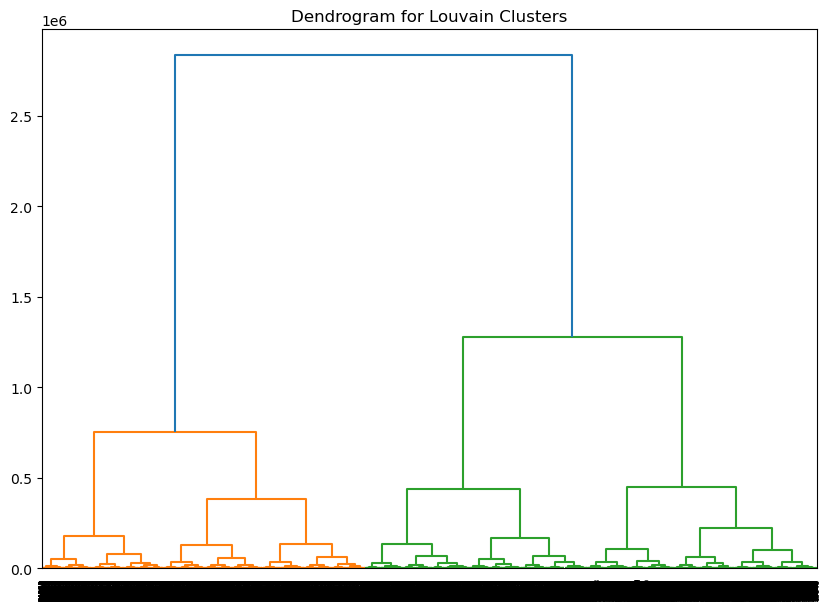

In [14]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np


# Apply the Louvain algorithm from NetworkX
louvain_comm = louvain_communities(G, seed=42)

# Compute modularity for Louvain clusters
louvain_modularity = modularity(G, louvain_comm)
print(f"Modularity for Louvain: {louvain_modularity}")

# Prepare clusters for the dendrogram
louvain_clusters = [list(community) for community in louvain_comm]
flat_clusters = np.concatenate(louvain_clusters)

# Ensure all items in flat_clusters are converted to floats and print correspondence
flat_clusters_float = []
for item in flat_clusters:
    if isinstance(item, (np.int32, np.float32, np.int64, np.float64)):
        flat_clusters_float.append(int(item))
        # print(f"Original: {item} -> Transformed: {float(item)}")
    else:
        transformed_value = int(ord(item) - ord('A'))
        flat_clusters_float.append(transformed_value)
        print(f"Original: {item} -> Transformed: {transformed_value} (ASCII code)")

flat_clusters_float = np.array(flat_clusters_float)

# Create a linkage matrix for the dendrogram
Z = linkage(flat_clusters_float.reshape(-1, 1), 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrogram for Louvain Clusters")
plt.show()

## A-Priori

Using the A-Priori algorithm with your dataset, you can uncover frequent patterns or associations that differentiate between fake and real reviews. Here's how you can approach this and what it might reveal:

In [9]:
# Define baskets (transactions)
transactions = df.apply(lambda row: 
    row['processed_text'] +  # Use the list from processed_text
    [f"category:{row['category']}", f"rating:{row['rating']}", f"label:{'real' if row['label'] == 'OR' else 'fake'}"], 
    axis=1
)

# Convert transactions to a list of lists
transactions = transactions.tolist()

In [11]:
from mlxtend.preprocessing import TransactionEncoder

# Encode transactions into a binary matrix
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

In [14]:
from mlxtend.frequent_patterns import apriori, association_rules
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df_on

TypeError: association_rules() missing 1 required positional argument: 'num_itemsets'

## Clustering

In [143]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Use TF-IDF vectors for clustering
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['processed_text'].apply(' '.join))


# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Evaluate clustering
score = davies_bouldin_score(tfidf_matrix.toarray(), df['cluster'])
print(f"Davies-Bouldin Index: {score}")

# Check cluster composition
cluster_counts = df.groupby(['cluster', 'label']).size().unstack()
print(cluster_counts)


Davies-Bouldin Index: 6.3724780282682
label      CG     OR
cluster             
0        1252    670
1        2233   1547
2        9737  13510
3        3568   2456
4        3426   2033


A Davies-Bouldin Index (DBI) over 6 suggests that the clusters are likely overlapping significantly and not well-separated. This high score generally indicates that the clustering is of poor quality, and the clusters may not be capturing distinct groups effectively. Here are some strategies you could try to improve clustering quality - so lets try silhouette score to see if we should choose other number of k's

In [117]:
from sklearn.metrics import silhouette_score

# Try different values of k and calculate DBI and silhouette score
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(tfidf_matrix)
    dbi = davies_bouldin_score(tfidf_matrix.toarray(), labels)
    silhouette_avg = silhouette_score(tfidf_matrix, labels)
    print(f'For k={k}, DBI={dbi:.2f}, Silhouette Score={silhouette_avg:.2f}')

For k=2, DBI=4.78, Silhouette Score=0.01
For k=3, DBI=7.88, Silhouette Score=0.01
For k=4, DBI=5.94, Silhouette Score=0.02
For k=5, DBI=6.37, Silhouette Score=0.02
For k=6, DBI=7.14, Silhouette Score=0.02
For k=7, DBI=7.23, Silhouette Score=0.02
For k=8, DBI=6.54, Silhouette Score=0.02
For k=9, DBI=6.56, Silhouette Score=0.02


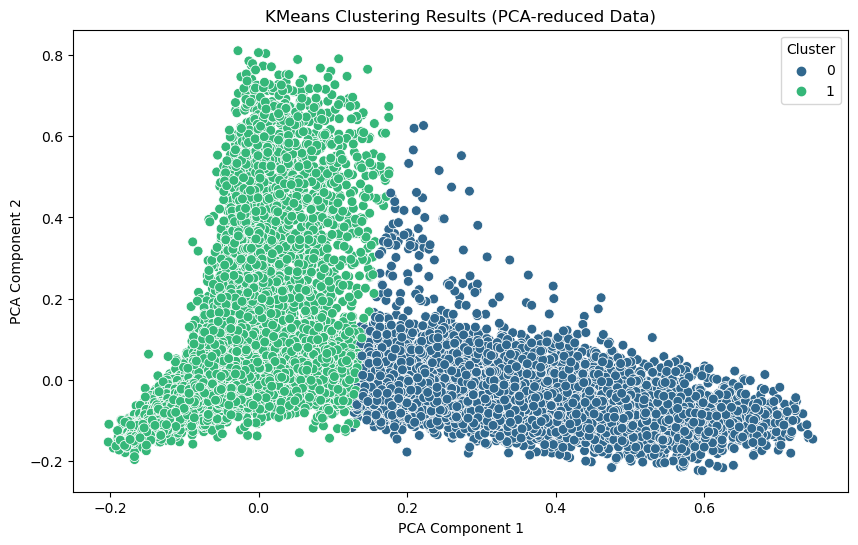

In [120]:
# Perform PCA to reduce the dimensions to 2 components for visualization
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['cluster'], palette="viridis", s=50)
plt.title("KMeans Clustering Results (PCA-reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

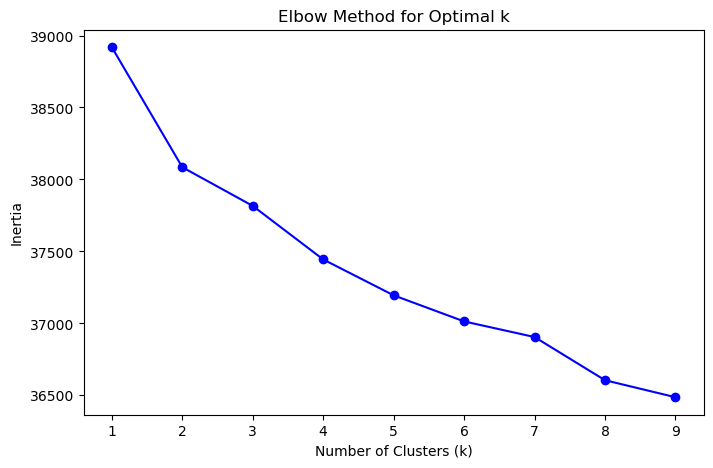

In [121]:
inertia = []
k_values = range(1, 10)

# Calculate inertia for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.show()

In [32]:
df.head(
)

,category,rating,label,text,label_binary,review_length,num_characters,num_words,num_sentences,processed_text
0,Home_and_Kitchen,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1,75,75,18,3,love this well made sturdy and very comfortab...
1,Home_and_Kitchen,5.0,CG,"love it, a great upgrade from the original. I...",1,80,80,19,2,love it a great upgrade from the original ive...
2,Home_and_Kitchen,5.0,CG,This pillow saved my back. I love the look and...,1,67,67,16,2,this pillow saved my back i love the look and ...
3,Home_and_Kitchen,1.0,CG,"Missing information on how to use it, but it i...",1,81,81,19,2,missing information on how to use it but it is...
4,Home_and_Kitchen,5.0,CG,Very nice set. Good quality. We have had the s...,1,85,85,20,3,very nice set good quality we have had the set...


In [34]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limit features for simplicity
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

In [35]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

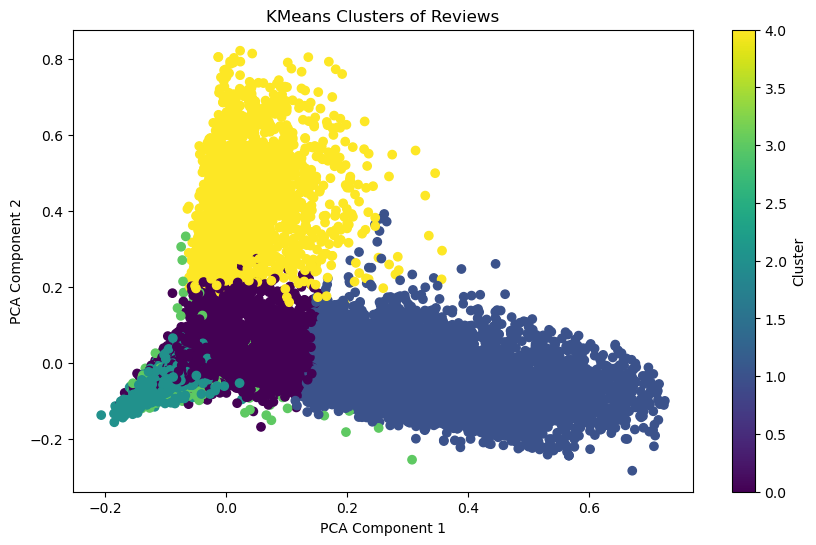

In [36]:
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())
plt.figure(figsize=(10, 6))
plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1], c=df['cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clusters of Reviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()